<a href="https://colab.research.google.com/github/kasmintalukdar/Book-Recommendation-System/blob/main/Book_recomndation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import re
from IPython.display import display, Image
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import recmetrics
warnings.filterwarnings("ignore")


In [2]:
!pip install recmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 7.6 MB/s 
     |████████████████████████████████| 13.2 MB 37.9 MB/s 
     |████████████████████████████████| 11.2 MB 33.6 MB/s 
     |████████████████████████████████| 1.6 MB 19.3 MB/s 
     |████████████████████████████████| 121 kB 43.9 MB/s 
     |████████████████████████████████| 965 kB 39.2 MB/s 
     |████████████████████████████████| 210 kB 47.0 MB/s 
     |████████████████████████████████| 316 kB 44.7 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 237 kB 42.1 MB/s 
     |████████████████████████████████| 140 kB 64.1 MB/s 
     |████████████████████████████████| 48 kB 4.8 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 51 kB 4.9 MB/s 
     |████████████████████████████████| 4.1 MB 32.6 MB/s 
     |████████████████████████████████

In [2]:
#loading dataset
Book_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dat/Books.csv")
rating_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dat/Ratings.csv")
user_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dat/Users.csv')

## Exploratory Data Analysis

### Book_df dataset

In [3]:
# first 5 rows of Book_df dataset
Book_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
#information about book_df dataset
Book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [5]:
#Checking duplicate observation
Book_df.duplicated().sum()

0

### Is there any repeated ISBN and Book-Title in the Book_df dataset

In [6]:
total_rows=Book_df.shape[0]
unique_isbn=len(Book_df["ISBN"].unique())
repeated_isbn=total_rows-unique_isbn
unique_title=len(Book_df["Book-Title"].unique())
repeated_title=total_rows-unique_title
print(f'number of repeated isbn: {repeated_isbn}')
print(f'number of repeated isbn: {repeated_title}')

number of repeated isbn: 0
number of repeated isbn: 29225


In [7]:
#checking null values
Book_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

### rating_df dataset

In [8]:
#first 5 rows of rating_df dataset
rating_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
#information about rating_df dataset
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [10]:
#Checking duplicate observation
rating_df.duplicated().sum()

0

In [11]:
#checking null values
rating_df.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

### user_df dataset

In [12]:
#first 5 rows of user_df dataset
user_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [13]:
#information about user_df dataset
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [14]:
#Checking duplicate observation
user_df.duplicated().sum()

0

In [15]:
#checking null values
user_df.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

### Top 10 authors with highest numbers of book

In [16]:
top_authors=Book_df.groupby('Book-Author').agg({'Book-Title':'count'}).sort_values(by="Book-Title",ascending=False).head(10).reset_index()
top_authors.rename(columns = {'Book-Author':'Author','Book-Title':"count"},inplace=True)

In [17]:
top_authors

,Author,count
0,Agatha Christie,632
1,William Shakespeare,567
2,Stephen King,524
3,Ann M. Martin,423
4,Carolyn Keene,373
5,Francine Pascal,372
6,Isaac Asimov,330
7,Nora Roberts,315
8,Barbara Cartland,307
9,Charles Dickens,302


Text(0, 0.5, 'Number Of Books')

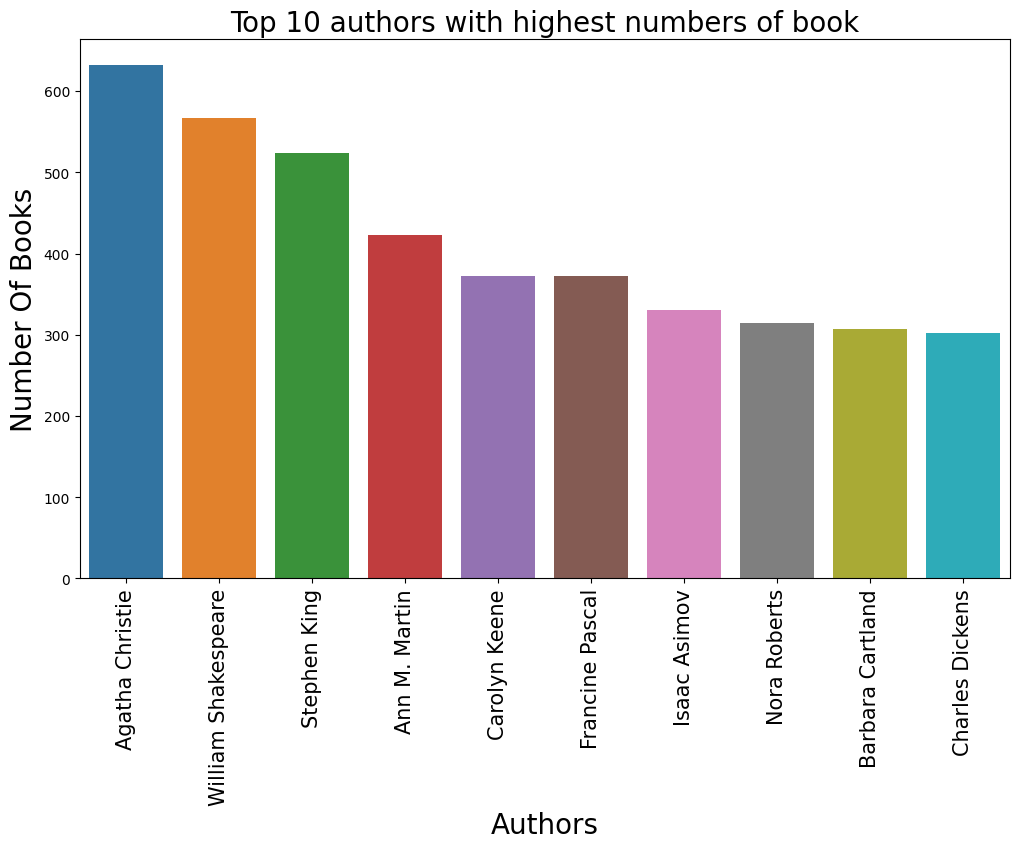

In [18]:
plt.figure(figsize=(12,7))
sns.barplot(data=top_authors, x="Author", y="count")
plt.title("Top 10 authors with highest numbers of book",fontsize=20);
plt.xticks(rotation=90,fontsize=15)
plt.xlabel("Authors",fontsize=20)
plt.ylabel("Number Of Books",fontsize=20)


### Unique values for year of publication column

In [19]:
Book_df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [20]:
#Checking the rows with wrong value
Book_df.loc[(Book_df['Year-Of-Publication'] == 'DK Publishing Inc') | (Book_df['Year-Of-Publication'] == 'Gallimard'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [21]:
# correct the 'Year of Publication' column
#ISBN = '0789466953'
Book_df.loc[Book_df.ISBN == '0789466953','Year-Of-Publication'] = 2000
Book_df.loc[Book_df.ISBN == '0789466953','Book-Author'] = "James Buckley"
Book_df.loc[Book_df.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
Book_df.loc[Book_df.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Book_df Come to Life(Level 4: Proficient Readers)"

#ISBN = '078946697X'
Book_df.loc[Book_df.ISBN == '078946697X','Year-Of-Publication'] = 2000
Book_df.loc[Book_df.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
Book_df.loc[Book_df.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
Book_df.loc[Book_df.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began(Level 4: Proficient Readers)"

#ISBN = '2070426769'
Book_df.loc[Book_df.ISBN == '2070426769','Year-Of-Publication'] = 2003
Book_df.loc[Book_df.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃƒ?Ã‚Â©zio"
Book_df.loc[Book_df.ISBN == '2070426769','Publisher'] = "Gallimard"
Book_df.loc[Book_df.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers'"


Book_df.loc[(Book_df.ISBN == '0789466953') | (Book_df.ISBN == '078946697X') | (Book_df.ISBN == '2070426769'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers'",Jean-Marie Gustave Le ClÃƒ?Ã‚Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [22]:
#Converting Year-Of-Publication column from string to integer
Book_df['Year-Of-Publication'] = Book_df['Year-Of-Publication'].apply(lambda x: int(x))

In [23]:
#fill the wrong entries with Nan values.
Book_df.loc[(Book_df['Year-Of-Publication'] >= 2006) | (Book_df['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

#replacing NaN values with median 
Book_df['Year-Of-Publication'].fillna(round(Book_df['Year-Of-Publication'].median()), inplace=True)

<AxesSubplot:xlabel='Year-Of-Publication', ylabel='Density'>

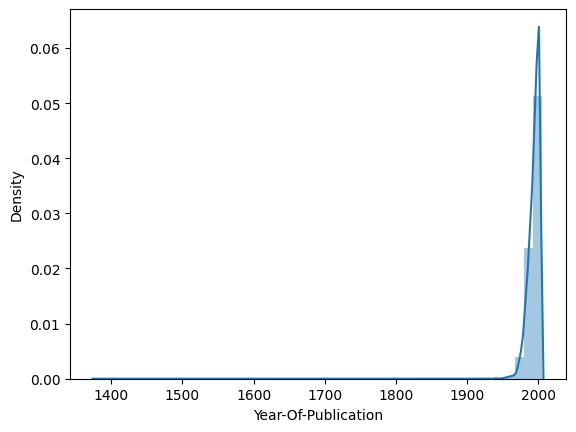

In [24]:
sns.distplot(Book_df['Year-Of-Publication'])

### Top 10 Publishers with highest numbers of book

In [25]:
top_Publisher=Book_df.groupby('Publisher').agg({'Book-Title':'count'}).sort_values(by="Book-Title",ascending=False).head(10).reset_index()
top_Publisher.rename(columns = {'Publisher':'Publisher','Book-Title':"count"},inplace=True)

In [26]:
top_Publisher

,Publisher,count
0,Harlequin,7535
1,Silhouette,4220
2,Pocket,3905
3,Ballantine Books,3783
4,Bantam Books,3646
5,Scholastic,3160
6,Simon &amp; Schuster,2971
7,Penguin Books,2844
8,Berkley Publishing Group,2771
9,Warner Books,2727


Text(0, 0.5, 'Number Of Books')

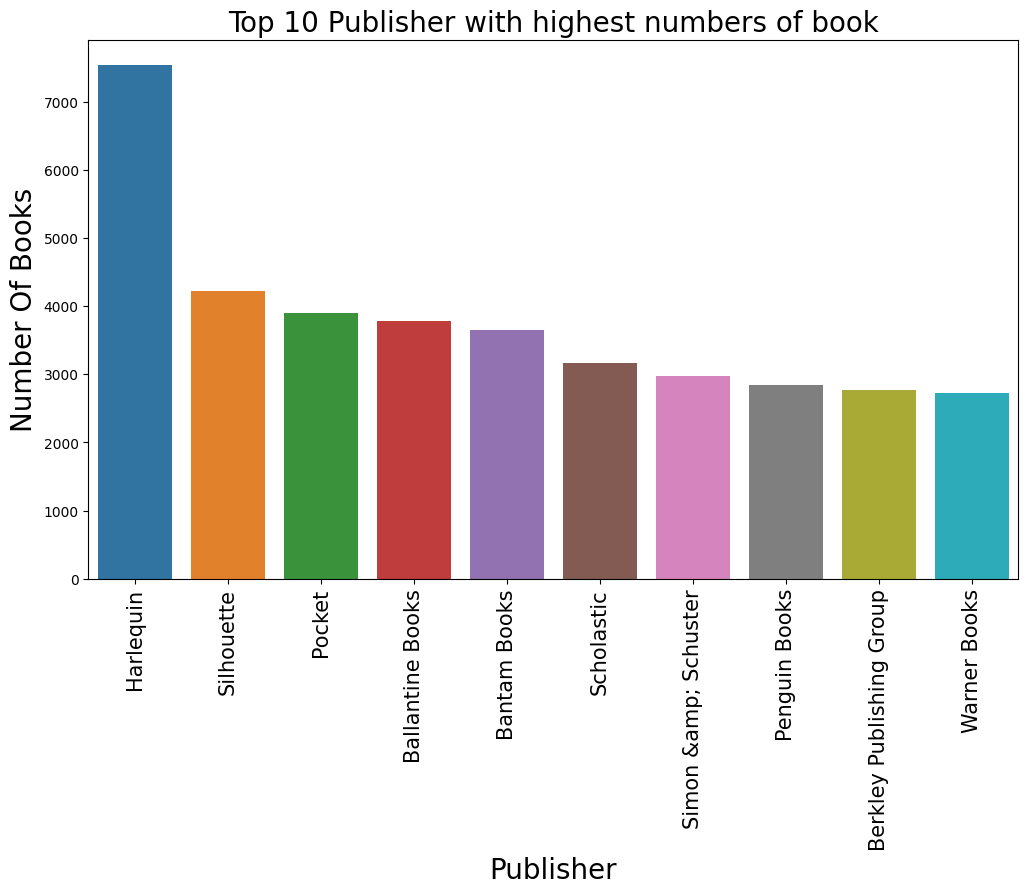

In [27]:
plt.figure(figsize=(12,7))
sns.barplot(data=top_Publisher, x="Publisher", y="count")
plt.title("Top 10 Publisher with highest numbers of book",fontsize=20);
plt.xticks(rotation=90,fontsize=15)
plt.xlabel("Publisher",fontsize=20)
plt.ylabel("Number Of Books",fontsize=20)


### Top Country with highest numbers of users

In [28]:
loction_df=user_df['Location'].apply(lambda x: pd.Series(str(x).split(",")))[2]

In [29]:
user_df['Country']=loction_df

In [30]:
user_location=user_df[['User-ID']]
user_location['Country']=loction_df

In [31]:
top_location=user_location.groupby('Country').agg({'User-ID':'count'}).sort_values(by="User-ID",ascending=False).head(16).reset_index()
top_location.rename(columns = {'Country':'Country','User-ID':"count"},inplace=True)

In [32]:
top_location=top_location.drop(7)

In [33]:
top_location

,Country,count
0,usa,139187
1,canada,21558
2,united kingdom,18286
3,germany,17022
4,spain,13095
5,australia,11723
6,italy,11242
8,france,3442
9,portugal,3306
10,new zealand,3071


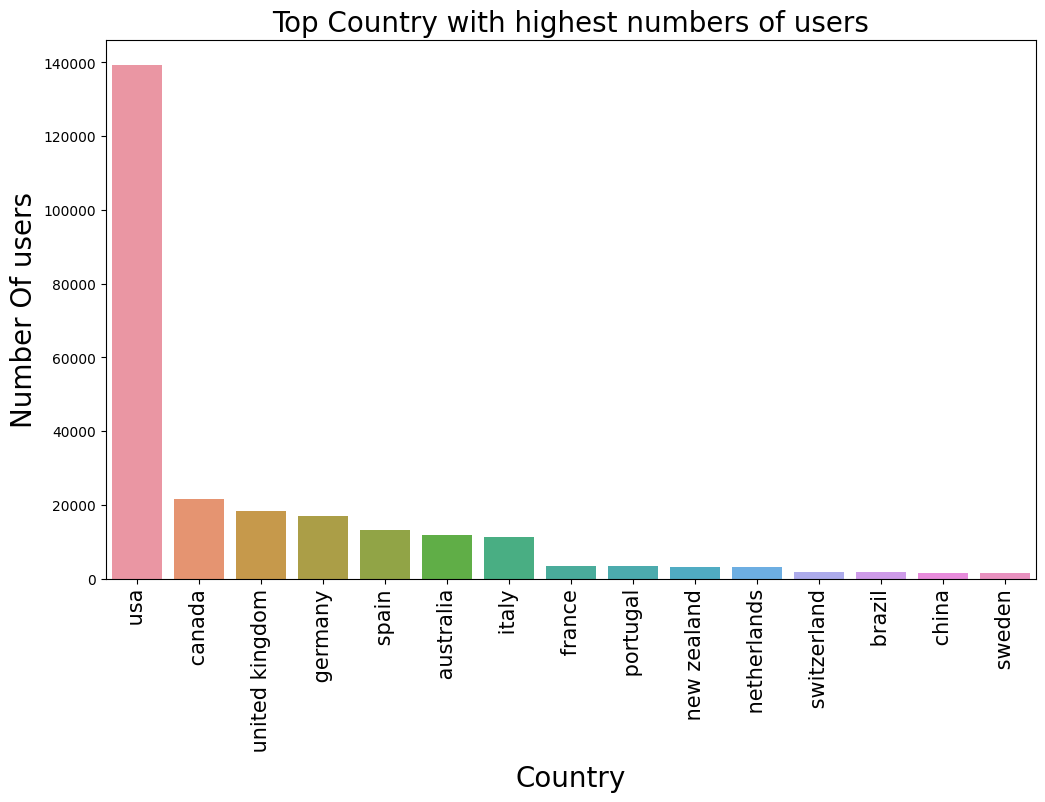

In [34]:
plt.figure(figsize=(12,7))
sns.barplot(data=top_location, x="Country", y="count")
plt.title("Top Country with highest numbers of users",fontsize=20);
plt.xticks(rotation=90,fontsize=15)
plt.xlabel("Country",fontsize=20)
plt.ylabel("Number Of users",fontsize=20);

### Anlyzing the age column

In [35]:
user_df['Age'].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

In [36]:
user_df[user_df['Age']==244]

,User-ID,Location,Age,Country
20856,20857,"stuttgart, baden-wuerttemberg, germany",244.0,germany


<AxesSubplot:xlabel='Age'>

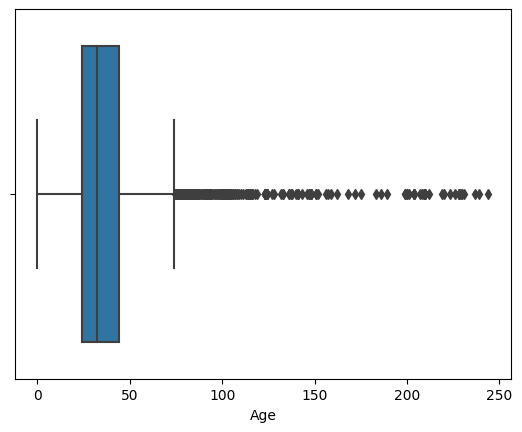

In [37]:
sns.boxplot(user_df['Age'])

<AxesSubplot:xlabel='Age', ylabel='Density'>

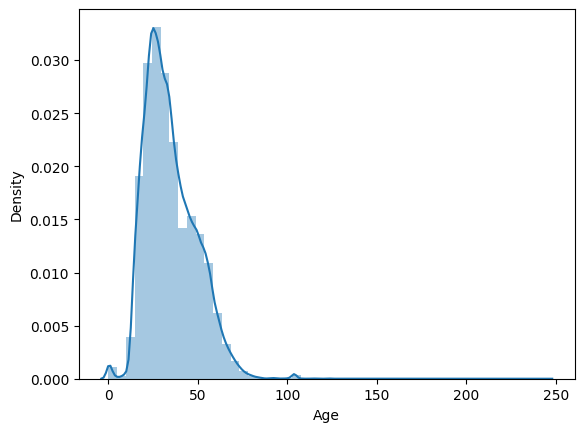

In [38]:
sns.distplot(user_df['Age'])

### Value count of ratings

In [39]:
rating_df['Book-Rating'].value_counts().reset_index().rename(columns={'index':'Rating','Book-Rating':'count'})

,Rating,count
0,0,716109
1,8,103736
2,10,78610
3,7,76457
4,9,67541
5,5,50974
6,6,36924
7,4,8904
8,3,5996
9,2,2759


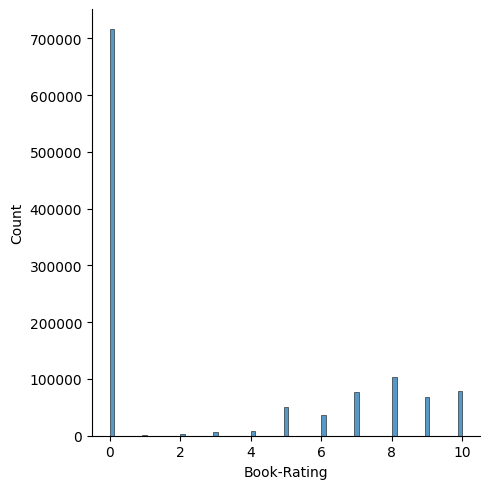

In [40]:
sns.displot(rating_df['Book-Rating'])

### rating distribution without considering 0

In [41]:
rating_without_0=rating_df[rating_df['Book-Rating']!=0]

In [42]:
rating_count=rating_without_0.groupby('Book-Rating').agg({'ISBN':'count'}).sort_values(by="ISBN",ascending=False).head(16).reset_index()
rating_count.rename(columns = {'Book-Rating':'Book-Rating','ISBN':"count"},inplace=True)

In [43]:
rating_count

,Book-Rating,count
0,8,103736
1,10,78610
2,7,76457
3,9,67541
4,5,50974
5,6,36924
6,4,8904
7,3,5996
8,2,2759
9,1,1770


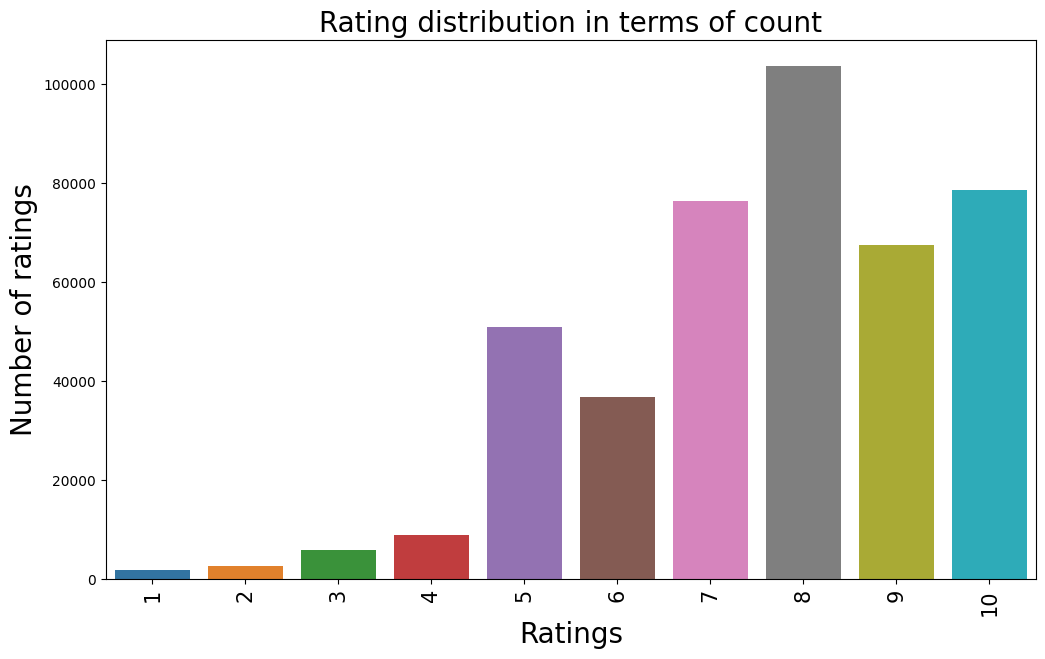

In [44]:
plt.figure(figsize=(12,7))
sns.barplot(data=rating_count, x="Book-Rating", y="count")
plt.title("Rating distribution in terms of count",fontsize=20);
plt.xticks(rotation=90,fontsize=15)
plt.xlabel("Ratings",fontsize=20)
plt.ylabel("Number of ratings",fontsize=20);

### Top User-ID with highest numbers of rating

In [45]:
#common book for both rating and book dataset
ratings_new = rating_df[rating_df.ISBN.isin(Book_df.ISBN)]

In [46]:
#common user for both rating and user dataset
ratings_new = ratings_new[ratings_new['User-ID'].isin(user_df['User-ID'])]

In [47]:
#checking shape
rating_df.shape,ratings_new.shape

((1149780, 3), (1031136, 3))

In [48]:

top_user_rating=ratings_new.groupby('User-ID').agg({'Book-Rating':'count'}).sort_values(by="Book-Rating",ascending=False).reset_index()
top_user_rating.rename(columns = {'User-ID':'User-ID','Book-Rating':"count"},inplace=True)
top_user_rating['User-ID']=top_user_rating['User-ID'].apply(lambda x:'UserId '+str(x)) 

In [49]:
top_user_rating=top_user_rating.head(15)
top_user_rating

,User-ID,count
0,UserId 11676,11144
1,UserId 198711,6456
2,UserId 153662,5814
3,UserId 98391,5779
4,UserId 35859,5646
5,UserId 212898,4289
6,UserId 278418,3996
7,UserId 76352,3329
8,UserId 110973,2971
9,UserId 235105,2943


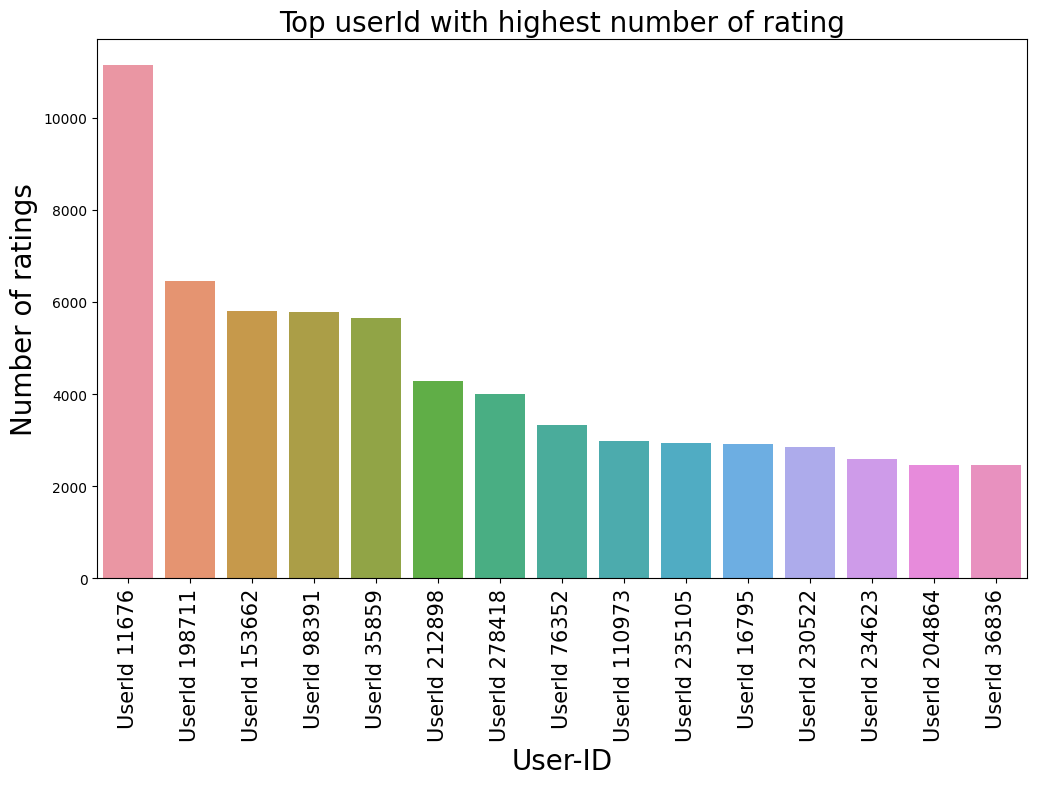

In [50]:
plt.figure(figsize=(12,7))
sns.barplot(data=top_user_rating, x="User-ID", y="count")
plt.title("Top userId with highest number of rating",fontsize=20);
plt.xticks(rotation=90,fontsize=15)
plt.xlabel("User-ID",fontsize=20)
plt.ylabel("Number of ratings",fontsize=20);

### Data pre-processing and feature engineering

In [51]:
#Rating ranges from 1 to 10 with no 0
rating_without_0=ratings_new[ratings_new['Book-Rating']!=0]

In [52]:
#merge dataset
Final_df_=user_df.copy()
Final_df_=pd.merge(Final_df_,rating_without_0,on='User-ID')
Final_df_=pd.merge(Final_df_,Book_df,on='ISBN')

In [53]:
Final_df=Final_df_[['User-ID','Age','ISBN','Book-Rating','Book-Title','Book-Author','Year-Of-Publication','Publisher','Image-URL-S']]

In [54]:
#checking shape
Final_df.shape

(383842, 9)

In [55]:
Final_df.head()

,User-ID,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,8,NaN,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
1,11676,NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,67544,30.0,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
3,116866,NaN,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
4,123629,NaN,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...


In [56]:
Final_df.isnull().sum()

User-ID                     0
Age                    114221
ISBN                        0
Book-Rating                 0
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
dtype: int64

### Handeling null values

<AxesSubplot:xlabel='Age', ylabel='Density'>

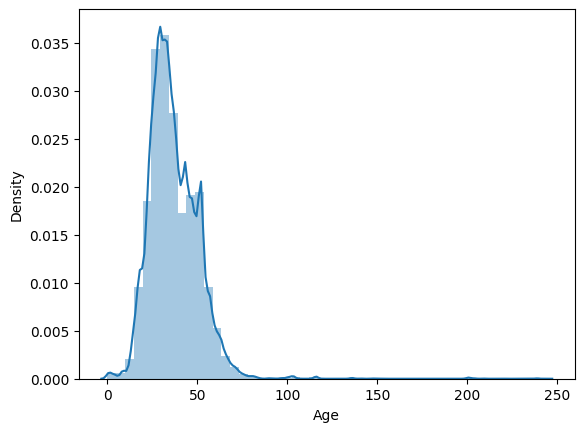

In [57]:
#age column
sns.distplot(Final_df['Age'])


In [58]:
Final_df.loc[(Final_df.Age > 100) | (Final_df.Age < 5), 'Age'] = np.nan

In [59]:
Final_df['Age'].isnull().sum()

115824

In [60]:
median_age=Final_df['Age'].median()

In [61]:
Final_df['Age'] = Final_df['Age'].fillna(median_age)

In [62]:
#Filling Nan value of Publisher with unknown
Final_df.Publisher.fillna('unknown',inplace=True)

In [63]:
#Filling Nan value of Book-Author with others
Final_df['Book-Author'].fillna('unknown',inplace=True)

In [64]:
Final_df.isnull().sum()

User-ID                0
Age                    0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
dtype: int64

In [65]:
Final_df.duplicated().sum()

0

## Popularity Based Recommender System

In [66]:
Final_df[['User-ID','Book-Title','Book-Rating']]

,User-ID,Book-Title,Book-Rating
0,8,Clara Callan,5
1,11676,Clara Callan,8
2,67544,Clara Callan,8
3,116866,Clara Callan,9
4,123629,Clara Callan,9
...,...,...,...
383837,278851,All Elevations Unknown: An Adventure in the He...,5
383838,278851,WebClasses From Scratch,5
383839,278851,Why stop?: A guide to Texas historical roadsid...,7
383840,278851,The Are You Being Served? Stories: 'Camping In...,7


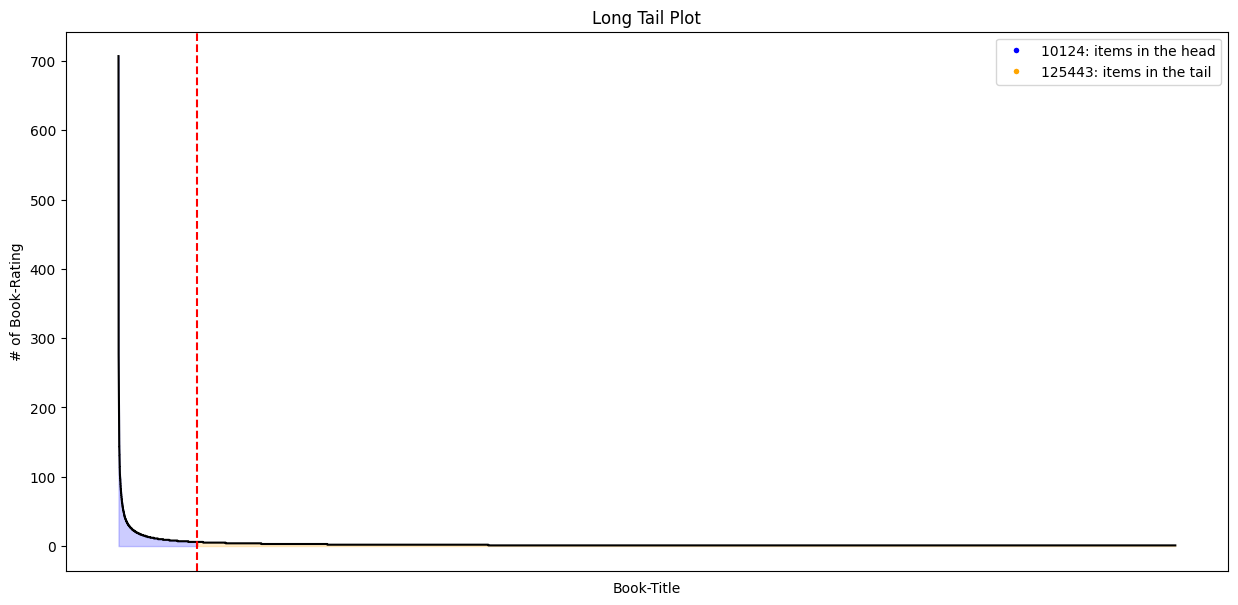

In [67]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=Final_df[['User-ID','Book-Title','Book-Rating']], 
             item_id_column="Book-Title", 
             interaction_type="Book-Rating", 
             percentage=0.5,
             x_labels=False)

In [68]:
#number of rating for each book
num_rating=Final_df.groupby('Book-Title').agg({'Book-Rating':'count'}).reset_index()
num_rating.rename(columns = {'Book-Title':'Book-Title','Book-Rating':"Rating_count"},inplace=True)
num_rating

,Book-Title,Rating_count
0,A Light in the Storm: The Civil War Diary of ...,1
1,"Ask Lily (Young Women of Faith: Lily Series, ...",1
2,Dark Justice,1
3,Earth Prayers From around the World: 365 Pray...,7
4,Final Fantasy Anthology: Official Strategy Gu...,2
...,...,...
135562,Ã?Â?bernachten mit Stil. Die schÃ?Â¶nsten Coun...,1
135563,Ã?Â?rger mit Produkt X. Roman.,3
135564,Ã?Â?sterlich leben.,1
135565,Ã?Â?stlich der Berge.,1


In [69]:
#averave rating for each book
avg_rating=Final_df.groupby('Book-Title').agg({'Book-Rating':'mean'}).reset_index()
avg_rating.rename(columns = {'Book-Title':'Book-Title','Book-Rating':"Avg_rating"},inplace=True)
avg_rating

,Book-Title,Avg_rating
0,A Light in the Storm: The Civil War Diary of ...,9.000000
1,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
2,Dark Justice,10.000000
3,Earth Prayers From around the World: 365 Pray...,7.142857
4,Final Fantasy Anthology: Official Strategy Gu...,10.000000
...,...,...
135562,Ã?Â?bernachten mit Stil. Die schÃ?Â¶nsten Coun...,8.000000
135563,Ã?Â?rger mit Produkt X. Roman.,7.000000
135564,Ã?Â?sterlich leben.,7.000000
135565,Ã?Â?stlich der Berge.,8.000000


In [70]:
#Merging num_rating and avg_rating dataframes on Book-Title column
popular_book_df = num_rating.merge(avg_rating,on='Book-Title')
popular_book_df

,Book-Title,Rating_count,Avg_rating
0,A Light in the Storm: The Civil War Diary of ...,1,9.000000
1,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.000000
2,Dark Justice,1,10.000000
3,Earth Prayers From around the World: 365 Pray...,7,7.142857
4,Final Fantasy Anthology: Official Strategy Gu...,2,10.000000
...,...,...,...
135562,Ã?Â?bernachten mit Stil. Die schÃ?Â¶nsten Coun...,1,8.000000
135563,Ã?Â?rger mit Produkt X. Roman.,3,7.000000
135564,Ã?Â?sterlich leben.,1,7.000000
135565,Ã?Â?stlich der Berge.,1,8.000000


In [71]:
#book with more than 200 review
popular_book_df = popular_book_df[popular_book_df['Rating_count']>=200]
popular_book_df

,Book-Title,Rating_count,Avg_rating
471,1st to Die: A Novel,236,7.711864
3064,A Painted House,366,7.398907
4046,A Time to Kill,214,8.009346
8134,Angels &amp; Demons,310,8.016129
15761,Bridget Jones's Diary,377,7.625995
29942,Divine Secrets of the Ya-Ya Sisterhood: A Novel,323,7.876161
31316,Dreamcatcher,214,7.219626
36288,Fahrenheit 451,204,8.549020
42293,Girl with a Pearl Earring,278,7.982014
43138,Good in Bed,247,8.044534


In [72]:
#popularity_score=0.7*Avg_rating+0.3*Rating_count
def popularity_score(df):
  df['popularity_score']=0.6*df['Avg_rating']+0.4*df['Rating_count']
  return df

In [73]:
popular_book=popularity_score(popular_book_df)
popular_book

,Book-Title,Rating_count,Avg_rating,popularity_score
471,1st to Die: A Novel,236,7.711864,99.027119
3064,A Painted House,366,7.398907,150.839344
4046,A Time to Kill,214,8.009346,90.405607
8134,Angels &amp; Demons,310,8.016129,128.809677
15761,Bridget Jones's Diary,377,7.625995,155.375597
29942,Divine Secrets of the Ya-Ya Sisterhood: A Novel,323,7.876161,133.925697
31316,Dreamcatcher,214,7.219626,89.931776
36288,Fahrenheit 451,204,8.549020,86.729412
42293,Girl with a Pearl Earring,278,7.982014,115.989209
43138,Good in Bed,247,8.044534,103.626721


In [74]:
#top 20 recommended book in terms of popularity
Most_popular_book=popular_book.sort_values(by='popularity_score',ascending=False).head(20).reset_index()
Most_popular_book

,index,Book-Title,Rating_count,Avg_rating,popularity_score
0,110229,The Lovely Bones: A Novel,707,8.185290,287.711174
1,132241,Wild Animus,581,4.390706,235.034423
2,102703,The Da Vinci Code,494,8.439271,202.663563
3,116196,The Secret Life of Bees,406,8.477833,167.486700
4,111950,The Nanny Diaries: A Novel,393,7.437659,161.662595
5,114960,The Red Tent (Bestselling Backlist),383,8.182768,158.109661
6,15761,Bridget Jones's Diary,377,7.625995,155.375597
7,3064,A Painted House,366,7.398907,150.839344
8,60688,Life of Pi,336,8.080357,139.248214
9,45374,Harry Potter and the Chamber of Secrets (Book 2),326,8.840491,135.704294


In [75]:
image_list=[]
for title in Most_popular_book['Book-Title']:
  
  url=str(Final_df[Final_df['Book-Title']==title]['Image-URL-S'].head(1))[8:57]
  image_list.append(url)

  

In [76]:
for path in image_list:
    img = Image(url=path,height=300,width=300)
    display(img)

## Collaborative Filtering Based Recommender System

In [77]:
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 0 to 383841
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              383842 non-null  int64  
 1   Age                  383842 non-null  float64
 2   ISBN                 383842 non-null  object 
 3   Book-Rating          383842 non-null  int64  
 4   Book-Title           383842 non-null  object 
 5   Book-Author          383842 non-null  object 
 6   Year-Of-Publication  383842 non-null  float64
 7   Publisher            383842 non-null  object 
 8   Image-URL-S          383842 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 29.3+ MB


In [78]:
#user with at least 3 rateing
rating_user_df=Final_df.groupby('User-ID').agg({'Book-Rating':'count'}).reset_index()
relible_user=rating_user_df[rating_user_df['Book-Rating']>=3]['User-ID'].tolist()
final_relible_user_df = Final_df[Final_df['User-ID'].isin(relible_user)]

In [79]:
#top 1 percent of most reviewed book
threshold = len(final_relible_user_df ['ISBN'].unique()) * 0.01

filter_books_list = final_relible_user_df ['ISBN'].value_counts().head(int(threshold)).index.to_list()
final_relible_user_df  = final_relible_user_df [final_relible_user_df ['ISBN'].isin(filter_books_list)]



In [80]:
final_relible_user_df.shape

(64086, 9)

In [81]:
# Applying Pivot table 
user_item_df=final_relible_user_df.pivot_table(index='User-ID',columns='Book-Title',values='Book-Rating').fillna(0)
user_item_df.head()

Book-Title,1984,1st to Die: A Novel,2010: Odyssey Two,2nd Chance,3rd Degree,4 Blondes,84 Charing Cross Road,A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,A Bend in the Road,...,"Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",Writ of Execution,Writing Down the Bones,Wuthering Heights,Xenocide (Ender Wiggins Saga (Paperback)),Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,"\O\"" Is for Outlaw""",stardust
User-ID,,,,,,,,,,,,,,,,,,,,,
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Collaborative Filtering Based Recommender System using cosine_similarity 

In [82]:
user_item_df_transposed=user_item_df.transpose()

In [83]:
#Applying cosine_similarity to pivot table
similarity_scores = cosine_similarity(user_item_df_transposed)
similarity_scores.shape

(1250, 1250)

In [118]:
def recommend_similer(book_name):
    # index fetch
    index = np.where(user_item_df_transposed.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:10]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = final_relible_user_df[final_relible_user_df['Book-Title'] == user_item_df_transposed.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        
        
        data.append(item)
    
    return data

In [119]:
recommend_similer('1984')

[['Brave New World', 'Aldous Huxley'],
 ['Animal Farm', 'George Orwell'],
 ["The Hitchhiker's Guide to the Galaxy", 'Douglas Adams'],
 ['The Drawing of the Three (The Dark Tower, Book 2)', 'Stephen King'],
 ['The Gunslinger (The Dark Tower, Book 1)', 'Stephen King'],
 ["Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death",
  'Kurt Vonnegut'],
 ["The Restaurant at the End of the Universe (Hitchhiker's Trilogy (Paperback))",
  'Douglas Adams'],
 ['The Catcher in the Rye', 'J.D. Salinger'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)', 'ANNE RICE']]

### Collaborative Filtering Based Recommender System using Singular Value Decomposition Method

In [85]:
user_item_df.shape

(13811, 1250)

In [86]:
#converting to numpy array
user_item_matrix=user_item_df.values

In [87]:
user_item_matrix.shape

(13811, 1250)

In [88]:
#fectorising matrix using svd
U, sigma, Vt = svds(user_item_matrix, k = 16)

In [89]:
sigma=np.diag(sigma)

In [90]:
U.shape,sigma.shape,Vt.shape

((13811, 16), (16, 16), (16, 1250))

In [91]:
#reconstructing the matrix
user_item_matrix_new = np.dot(np.dot(U, sigma), Vt) 
user_item_matrix_new

array([[ 1.15198887e-02,  1.76138526e-02,  5.10332845e-03, ...,
         6.29353586e-04,  5.55032329e-03,  1.81166065e-03],
       [-1.64984890e-02,  4.75876175e-01, -5.35392943e-02, ...,
        -9.12689217e-02, -3.69186994e-02,  2.04459761e-02],
       [ 1.06865203e-03,  7.08212163e-02, -1.00160754e-02, ...,
        -2.66859119e-02, -1.40928226e-03, -2.37210790e-02],
       ...,
       [ 7.64889581e-02, -2.93419633e-01,  4.90063544e-02, ...,
         8.22652777e-02, -1.31610855e-02, -1.48963424e-02],
       [-1.66342464e-04,  1.57218395e-02,  5.31666619e-04, ...,
         1.87087648e-02,  2.50349657e-02,  1.71479040e-02],
       [-1.74346498e-02,  9.44221099e-02, -2.34936815e-03, ...,
         4.94379602e-03,  5.86847345e-02,  6.21423719e-03]])

In [92]:
user_item_matrix_new .shape

(13811, 1250)

In [93]:
#Converting the reconstructed matrix back to a Pandas dataframe
final_svd_df = pd.DataFrame(user_item_matrix_new, columns = user_item_df.columns, index=list(user_item_df.index)).transpose()
final_svd_df.head()

,99,114,165,242,243,244,254,388,424,440,...,278582,278586,278633,278663,278694,278773,278832,278843,278851,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.011520,-0.016498,0.001069,0.051223,-0.049149,0.231309,0.409780,0.017890,0.076655,0.030008,...,0.106294,-0.018893,-0.031124,0.013804,-0.016070,-0.027506,-0.030409,0.076489,-0.000166,-0.017435
1st to Die: A Novel,0.017614,0.475876,0.070821,-0.016669,0.426457,0.063179,0.207734,0.000127,-0.009998,-0.006438,...,0.639242,0.019273,-0.001869,-0.004224,0.068642,0.072258,0.041441,-0.293420,0.015722,0.094422
2010: Odyssey Two,0.005103,-0.053539,-0.010016,0.012692,-0.031243,0.067341,0.102214,0.008987,0.010508,0.006284,...,-0.004688,0.003132,0.066965,0.003801,-0.006515,-0.008609,0.001744,0.049006,0.000532,-0.002349
2nd Chance,-0.001404,0.467756,0.054473,-0.020312,0.125163,0.234761,-0.107231,-0.017580,-0.053329,-0.004954,...,0.499641,0.018961,0.049365,-0.036172,0.046446,0.062039,0.031647,-0.423054,-0.005002,0.064031
3rd Degree,-0.003839,0.132261,0.001822,-0.008487,-0.067965,0.093682,0.041233,-0.013323,-0.025678,-0.001015,...,0.170987,0.008126,0.013661,-0.020453,0.009602,0.021996,0.012408,-0.127397,-0.000047,0.006275


In [94]:
final_svd_df.shape

(1250, 13811)

### Prediction

In [95]:
def recommender(svd_df,user_id, items_to_ignore=[], topn=10):
  sorted_recomanded_predictions = svd_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recomandStrength'})
  top_recomand_book=sorted_recomanded_predictions[~sorted_recomanded_predictions['Book-Title'].isin(items_to_ignore)].sort_values('recomandStrength', ascending = False).head(topn)
  return top_recomand_book 

In [96]:
recommender(final_svd_df,114, items_to_ignore=[], topn=10)

,Book-Title,recomandStrength
0,The Da Vinci Code,2.248182
1,Angels &amp; Demons,2.182762
2,The Red Tent (Bestselling Backlist),1.050664
3,The Nanny Diaries: A Novel,0.923243
4,The Summons,0.900350
5,A Painted House,0.685134
6,The Fellowship of the Ring (The Lord of the Ri...,0.684829
7,Timeline,0.562416
8,The Hobbit : The Enchanting Prelude to The Lor...,0.555354
9,Digital Fortress : A Thriller,0.533706


In [97]:
user_id_list=user_item_df.index.tolist()

In [98]:
def recommend_for_all(recommender,user_id_list,svd_df):
  user_item_dict={}
  
  for user_id in user_id_list:
    rec=recommender(svd_df,user_id, items_to_ignore=[], topn=15)
    user_item_dict[user_id]=rec['Book-Title'].tolist()
  return user_item_dict 


In [99]:
svd_pred=recommend_for_all(recommender,user_id_list,final_svd_df)

In [100]:
user_id_recomanded_book=pd.DataFrame(list(svd_pred.items())).rename(columns={0:"User_id",1:"svd_recomanded_book"})

In [101]:
user_id_recomanded_book.shape

(13811, 2)

### Actual Rateing

In [102]:
def actual_rateing(user_item_df,user_id, items_to_ignore=[], topn=10):
  sorted_actual_rateing = user_item_df.transpose()[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'Rating'})
  top_rating_book=sorted_actual_rateing[~sorted_actual_rateing['Book-Title'].isin(items_to_ignore)].sort_values('Rating', ascending = False).head(topn)
  return top_rating_book 

In [103]:
def rateing_for_all(actual_rateing,user_id_list,user_item_df):
  user_item_dict={}
  
  for user_id in user_id_list:
    rec=actual_rateing(user_item_df,user_id, items_to_ignore=[], topn=10)
    user_item_dict[user_id]=rec['Book-Title'].tolist()
  return user_item_dict 

In [104]:
actual_rating=rateing_for_all(actual_rateing,user_id_list,user_item_df)

In [105]:
user_id_top_rated_book=pd.DataFrame(list(actual_rating.items())).rename(columns={0:"User_id",1:"Actual_top_rated_book"})

In [106]:
user_id_top_rated_book.shape

(13811, 2)

In [107]:
result_from_svd=user_id_top_rated_book.merge(user_id_recomanded_book,on="User_id")

In [108]:
pd.set_option('display.max_colwidth', None)

result_from_svd

,User_id,Actual_top_rated_book,svd_recomanded_book
0,99,"[Rich Dad, Poor Dad: What the Rich Teach Their Kids About Money--That the Poor and Middle Class Do Not!, The Pillars of the Earth, Code to Zero, A Prayer for Owen Meany, 2010: Odyssey Two, 2nd Chance, 3rd Degree, 4 Blondes, 84 Charing Cross Road, A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))]","[The Da Vinci Code, The Lovely Bones: A Novel, The Fellowship of the Ring (The Lord of the Rings, Part 1), The Firm, To Kill a Mockingbird, The Hobbit : The Enchanting Prelude to The Lord of the Rings, The Client, The Chamber, The Return of the King (The Lord of the Rings, Part 3), Angels &amp; Demons, The Two Towers (The Lord of the Rings, Part 2), The Secret Life of Bees, A Time to Kill, The Pelican Brief, The Rainmaker]"
1,114,"[Angels &amp; Demons, Dead Aim, The Beach House, House of Sand and Fog, A Child Called \It\"": One Child's Courage to Survive"", 3rd Degree, 4 Blondes, 84 Charing Cross Road, A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)), A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash]","[The Da Vinci Code, Angels &amp; Demons, The Red Tent (Bestselling Backlist), The Nanny Diaries: A Novel, The Summons, A Painted House, The Fellowship of the Ring (The Lord of the Rings, Part 1), Timeline, The Hobbit : The Enchanting Prelude to The Lord of the Rings, Digital Fortress : A Thriller, The Two Towers (The Lord of the Rings, Part 2), The Return of the King (The Lord of the Rings, Part 3), The Five People You Meet in Heaven, 1st to Die: A Novel, 2nd Chance]"
2,165,"[Little Altars Everywhere: A Novel, The Beach House, Code to Zero, A Prayer for Owen Meany, 2010: Odyssey Two, 2nd Chance, 3rd Degree, 4 Blondes, 84 Charing Cross Road, A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))]","[The Red Tent (Bestselling Backlist), The Nanny Diaries: A Novel, Divine Secrets of the Ya-Ya Sisterhood: A Novel, Where the Heart Is (Oprah's Book Club (Paperback)), The Pilot's Wife : A Novel, The Notebook, A Painted House, The Poisonwood Bible: A Novel, The Five People You Meet in Heaven, Good in Bed, Little Altars Everywhere: A Novel, Angels &amp; Demons, Bridget Jones's Diary, The Summons, Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson]"
3,242,"[The Martian Chronicles, A Child Called \It\"": One Child's Courage to Survive"", 3rd Degree, 4 Blondes, 84 Charing Cross Road, A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)), A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash, A Prayer for Owen Meany, A Bend in the Road, A Civil Action]","[The Fellowship of the Ring (The Lord of the Rings, Part 1), Life of Pi, To Kill a Mockingbird, The Hobbit : The Enchanting Prelude to The Lord of the Rings, The Return of the King (The Lord of the Rings, Part 3), The Two Towers (The Lord of the Rings, Part 2), The Catcher in the Rye, Jurassic Park, Fahrenheit 451, Silence of the Lambs, 1984, The Firm, Lord of the Flies, Ender's Game (Ender Wiggins Saga (Paperback)), Stupid White Men ...and Other Sorry Excuses for the State of the Nation!]"
4,243,"[Memoirs of a Geisha, The Bean Trees, The General's Daughter, Me Talk Pretty One Day, Unnatural Exposure, The Pilot's Wife : A Novel, A Map of the World, The God of Small Things, River, Cross My Heart, A Painted House]","[Where the Heart Is (Oprah's Book Club (Paperback)), The Red Tent (Bestselling Backlist), The Secret Life of Bees, A Painted House, Divine Secrets of the Ya-Ya Sisterhood: A Novel, The Pilot's Wife : A Novel, The Poisonwood Bible: A Novel, Snow Falling on Cedars, The Firm, Summer Sisters, House of Sand and Fog, Little Altars Everywhere: A Novel, The Bean Trees, The Reader, Girl with a Pearl Earring]"
...,...,...,...
13806,278773,"[Mystic River, A New Song (Mitford Years (Paperback)), Sticks &amp; Scones, A Child Called \I

##Random Recomender

In [109]:
#make recommendations for all members in the result_from_svd data

ran_recs = []
for user in result_from_svd.index:
    random_predictions = Final_df['Book-Title'].sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
result_from_svd['random_predictions'] = ran_recs

In [110]:
result_from_svd

,User_id,Actual_top_rated_book,svd_recomanded_book,random_predictions
0,99,"[Rich Dad, Poor Dad: What the Rich Teach Their Kids About Money--That the Poor and Middle Class Do Not!, The Pillars of the Earth, Code to Zero, A Prayer for Owen Meany, 2010: Odyssey Two, 2nd Chance, 3rd Degree, 4 Blondes, 84 Charing Cross Road, A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))]","[The Da Vinci Code, The Lovely Bones: A Novel, The Fellowship of the Ring (The Lord of the Rings, Part 1), The Firm, To Kill a Mockingbird, The Hobbit : The Enchanting Prelude to The Lord of the Rings, The Client, The Chamber, The Return of the King (The Lord of the Rings, Part 3), Angels &amp; Demons, The Two Towers (The Lord of the Rings, Part 2), The Secret Life of Bees, A Time to Kill, The Pelican Brief, The Rainmaker]","[The Professor's House (Vintage Classic), Icy Sparks, I Am a Gymnast (Young Dreamers), It, Die falsche FÃ?Â¤hrte., The Magician's Assistant, When the Wind Blows, Centaur Aisle, Sullivan's Island: A Lowcountry Tale, A Bad Spell for the Worst Witch (Young Puffin Books)]"
1,114,"[Angels &amp; Demons, Dead Aim, The Beach House, House of Sand and Fog, A Child Called \It\"": One Child's Courage to Survive"", 3rd Degree, 4 Blondes, 84 Charing Cross Road, A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)), A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash]","[The Da Vinci Code, Angels &amp; Demons, The Red Tent (Bestselling Backlist), The Nanny Diaries: A Novel, The Summons, A Painted House, The Fellowship of the Ring (The Lord of the Rings, Part 1), Timeline, The Hobbit : The Enchanting Prelude to The Lord of the Rings, Digital Fortress : A Thriller, The Two Towers (The Lord of the Rings, Part 2), The Return of the King (The Lord of the Rings, Part 3), The Five People You Meet in Heaven, 1st to Die: A Novel, 2nd Chance]","[A Day of Rhymes, The Baby Bargain (Zebra Bouquet Romances, No 3), How to Talk to Your Cat, Lincoln's Dreams, The Magic and Mystery of Trees: A Beginner's Guide, Driven, Walt Disney Pictures presents The rescuers downunder (A Little golden book), Katzenauge. ErzÃ?Â¤hlungen vom Meister des Horrors., Riverwind the Plainsman (Dragonlance: Preludes, Volume 4), The Fellowship of the Ring (The Lord of the Rings, Part 1)]"
2,165,"[Little Altars Everywhere: A Novel, The Beach House, Code to Zero, A Prayer for Owen Meany, 2010: Odyssey Two, 2nd Chance, 3rd Degree, 4 Blondes, 84 Charing Cross Road, A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))]","[The Red Tent (Bestselling Backlist), The Nanny Diaries: A Novel, Divine Secrets of the Ya-Ya Sisterhood: A Novel, Where the Heart Is (Oprah's Book Club (Paperback)), The Pilot's Wife : A Novel, The Notebook, A Painted House, The Poisonwood Bible: A Novel, The Five People You Meet in Heaven, Good in Bed, Little Altars Everywhere: A Novel, Angels &amp; Demons, Bridget Jones's Diary, The Summons, Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson]","[Pope Joan (Ballantine Reader's Circle), Antigone (French Language Edition), Russka : The Novel of Russia, FROM POTTER'S FIELD, No Surrender: A Novel, A Cold Touch Of Ice: A Mamur Zapt Mystery (Mamur Zapt Mysteries), The Cat Who Played Brahms, Gold of Troy, Number9dream, The Strong Shall Live]"
3,242,"[The Martian Chronicles, A Child Called \It\"": One Child's Courage to Survive"", 3rd Degree, 4 Blondes, 84 Charing Cross Road, A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)), A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash, A Prayer for Owen Meany, A Bend in the Road, A Civil Action]","[The Fellowship of the Ring (The Lord of the Rings, Part 1), Life of Pi, To Kill a Mockingbird, The Hobbit : The Enchanting Prelude to The Lord of the Rings, The Return of the King (The Lord of the Rings, Part 3), The Two Towers (The Lord of t

### Model Evaluation

In [111]:
actual = result_from_svd.Actual_top_rated_book.values.tolist()
cf_predictions = result_from_svd.svd_recomanded_book.values.tolist()
random_predictions = result_from_svd.random_predictions.values.tolist()

In [112]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
pop_mark

[0.022663094634711462,
 0.03068930562595033,
 0.035615330774986124,
 0.03940035720319552,
 0.041914295368426134,
 0.04378478507469891,
 0.04545736490237251,
 0.04684575097144788,
 0.047991375634558596,
 0.049127426608420025]

In [113]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0002534211860111506,
 0.00034030844978640213,
 0.00042236864335191754,
 0.0004766731832114498,
 0.0005230130572249173,
 0.0005712837593222793,
 0.0006033492971440985,
 0.0006286914157452134,
 0.0006536312784955172,
 0.0006862140024112363]

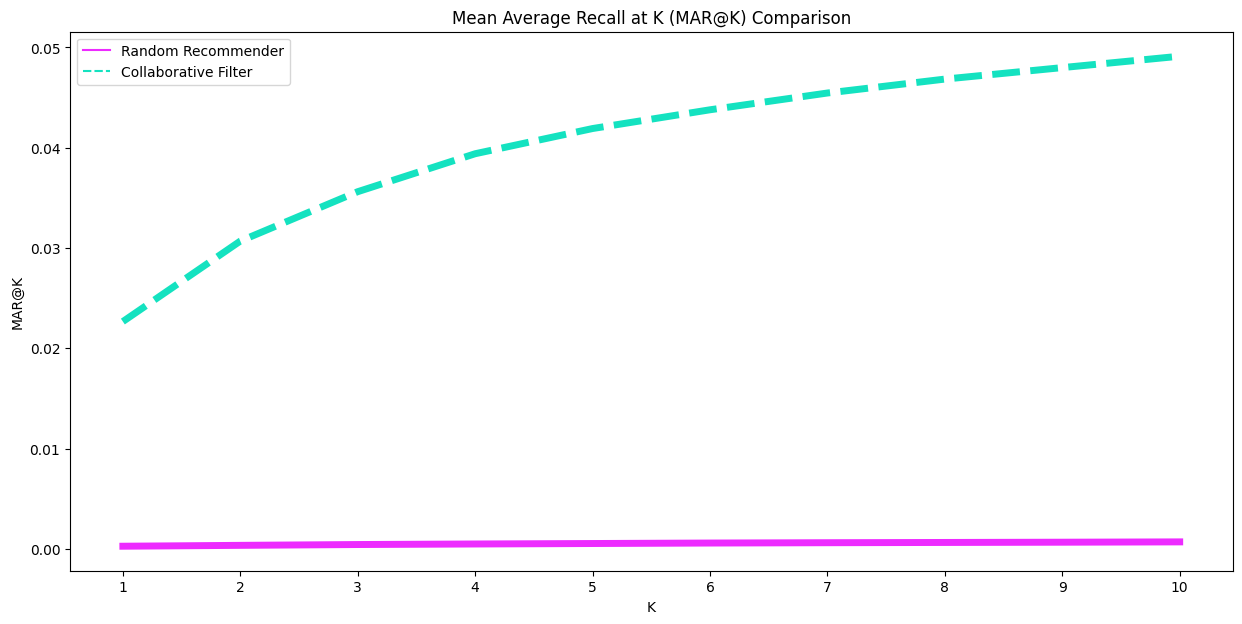

In [114]:
mark_scores = [random_mark, pop_mark]
index = range(1,10+1)
names = ['Random Recommender','Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)